# Fractal Generator Multithreading

Experimenting with generating fractals using multithreading. We'll be generating the mandelbrot set

In [19]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['image.cmap'] = 'viridis'
import threading
import time
from functools import reduce

# Helper functions
pixel_constant = lambda i, j, size: complex(i - size[0]/2, j - size[1]/2)/max(size)*4
iterator = lambda z, c: z**2 + c

To determine a baseline, single-threaded fractal generation performance

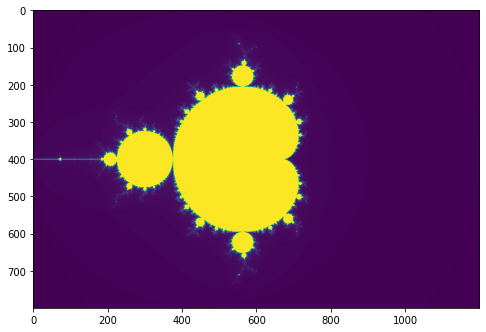

CPU times: user 12.6 s, sys: 21.3 ms, total: 12.7 s
Wall time: 12.7 s


In [31]:
%%time

# Make image array
size = 1200, 800
array = np.zeros((size[1], size[0]), dtype=np.uint8)

# Run fractal generation algorithm
for i in range(size[0]):
    for j in range(size[1]):
        c = pixel_constant(i, j, size)
        z = 0
        n = 0
        while abs(z) < 2 and n < 255:
            z = iterator(z, c)
            n += 1
        array[j,i] = n
        
# Display fractal
plt.imshow(array)
plt.show();

For multithreaded, define a worker function

In [29]:
def worker(i0, i1, j0, j1, size):
    """
    Compute a fraction of the image
    """
    global array
    for i in range(i0, i1):
        for j in range(j0, j1):
            # Initialize
            c = pixel_constant(i, j, size)
            z = 0
            n = 0
            
            # Run iteration
            while abs(z) < 2 and n < 255:
                z = iterator(z, c)
                n += 1
            
            # Set array
            array[j, i] = n

2-thread performance. 

I'm not sure if numpy arrays can trigger any race conditions, even though we're indexing different spots in the array. I guess in the limit it might be okay, unless python takes that

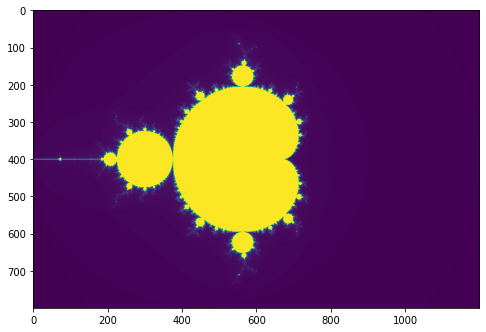

CPU times: user 10 s, sys: 38.9 ms, total: 10.1 s
Wall time: 10 s


In [51]:
%%time

# Array
size = 1200, 800
array = np.zeros((size[1], size[0]), dtype=np.uint8)

# Create threads
threads = [
    threading.Thread(target=worker, args=(0, size[0]//2, 0, size[1], size)),
    threading.Thread(target=worker, args=(size[0]//2, size[0], 0, size[1], size))
]

# Run threads in parallel
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()

# Display final array
plt.imshow(array)
plt.show();

4-thread performance. The macbook I'm running this on is a 6-core, so my guess is peak performance will be at 12 (since hyperthreading)

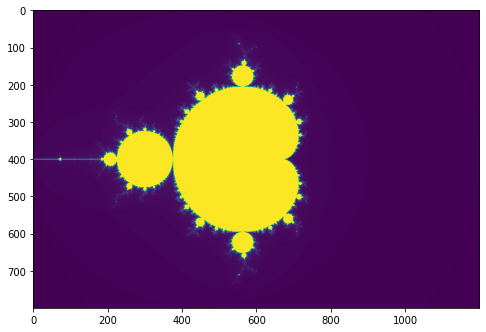

CPU times: user 10.2 s, sys: 77.4 ms, total: 10.3 s
Wall time: 10.2 s


In [37]:
%%time

# Array
size = 1200, 800
array = np.zeros((size[1], size[0]), dtype=np.uint8)

# Create threads
threads = [
    threading.Thread(target=worker, args=(0,          size[0]//2, 0,          size[1]//2, size)),
    threading.Thread(target=worker, args=(size[0]//2, size[0],    0,          size[1]//2, size)),
    threading.Thread(target=worker, args=(0,          size[0]//2, size[1]//2, size[1],    size)),
    threading.Thread(target=worker, args=(size[0]//2, size[0],    size[1]//2, size[1],    size))
]

# Run threads in parallel
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()

# Display final array
plt.imshow(array)
plt.show();

Create an effective sharding algorithm for 2d images. I think it entails finding two integer factors for threads (as long as the thread number isn't a prime number), then we shard each dimension by one factor and loop through each.

In [41]:
# Memoized prime numbers
primes = [2, 3, 5, 7, 11, 13, 15, 19, 23, 27, 29, 31, 37, 39, 41]

def prime_factors_of(N):
    """
    Iterator find prime factors of N
    """
    for p in primes:
        if p > N:
            break
        x = N
        while x % p == 0:
            yield p
            x //= p

def factorize(N):
    """
    Return two factors of N that are as equal as possible
    """
    n = 1
    m = N
    for f in prime_factors_of(N):
        np = n * f
        mp = m // f
        if abs(n - m) < abs(np - mp):
            break
        n = np
        m = mp
    return n, m

tests = [4, 6, 8, 12, 18, 24, 32, 64]
for test in tests:
    print(test, '=', ' * '.join(str(n) for n in factorize(test)))

4 = 2 * 2
6 = 2 * 3
8 = 4 * 2
12 = 4 * 3
18 = 6 * 3
24 = 4 * 6
32 = 8 * 4
64 = 8 * 8


If the thread count is a prime number, then we can only shard one dimension

In [49]:
def split_range(rX, n):
    """
    Split range into n even chunks
    """
    rI = rX // n
    rp = list(range(0, rX + 1, rI))
    return [ (rp[i-1], rp[i]) for i in range(1,len(rp)) ]
    

def shard(size, threads):
    """
    Shard size into thread ranges
    """
    if threads not in primes:
        factors = factorize(threads)
        xs = split_range(size[0], max(*factors))
        ys = split_range(size[1], min(*factors))
        ranges = []
        for x0, x1 in xs:
            ranges.extend([ (x0, x1, y0, y1) for y0, y1 in ys ])
        return ranges
    else:
        xs = split_range(size[0], threads)
        return [ (x0, x1, 0, size[1]) for x0, x1 in xs ]
    
size = 1200, 800
threadcount = 6
display(shard(size, threadcount))

[(0, 400, 0, 400),
 (0, 400, 400, 800),
 (400, 800, 0, 400),
 (400, 800, 400, 800),
 (800, 1200, 0, 400),
 (800, 1200, 400, 800)]

Do the same thing again except use the sharding algorithm

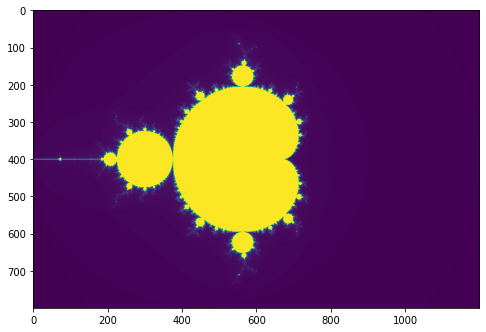

CPU times: user 10.4 s, sys: 85.8 ms, total: 10.5 s
Wall time: 10.4 s


In [45]:
%%time

# Params
size = 1200, 800
threadcount = 4

# Array
array = np.zeros((size[1], size[0]), dtype=np.uint8)

# Create threads
threads = [
    threading.Thread(target=worker, args=(xyrange + (size,)))
    for xyrange in shard(size, threadcount)
]

# Run threads in parallel
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()

# Display final array
plt.imshow(array)
plt.show();

Now with 6 threads

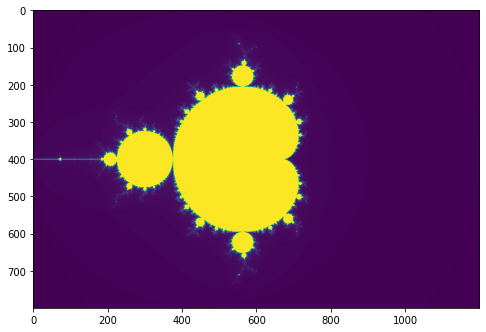

CPU times: user 10.8 s, sys: 114 ms, total: 10.9 s
Wall time: 10.9 s


In [46]:
%%time

# Params
size = 1200, 800
threadcount = 6

# Array
array = np.zeros((size[1], size[0]), dtype=np.uint8)

# Create threads
threads = [
    threading.Thread(target=worker, args=(xyrange + (size,)))
    for xyrange in shard(size, threadcount)
]

# Run threads in parallel
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()

# Display final array
plt.imshow(array)
plt.show();

So it looks like after two threads, the performance drops... It may be an issue with how jupyter is implemented